In [ ]:
from pyspark.sql import SparkSession, functions as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
from functools import reduce
from pyspark.sql.types import *
import os

In [ ]:
spark = SparkSession.builder \
    .appName("PAMAP2_Dataset") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# путь до файлов с данными
DS_FILES_PATH = "/content/drive/MyDrive/PAMAP2_Dataset/Protocol/*.dat"

# разделитель - пробел
DELIMETER = " "

# количество столбцов из описания набора данных
COLUMNS_COUNT = 54

# названия столбцов из описания набора данных
ds_columns = ["timestamp", "activityID", "heart_rate",
"IMU_hand_temperature",
"IMU_hand_acc_16g_x", "IMU_hand_acc_16g_y", "IMU_hand_acc_16g_z", "IMU_hand_acc_6g_x", "IMU_hand_acc_6g_y", "IMU_hand_acc_6g_z",
"IMU_hand_gyr_x", "IMU_hand_gyr_y", "IMU_hand_gyr_z",
"IMU_hand_mag_x", "IMU_hand_mag_y", "IMU_hand_mag_z",
"IMU_hand_ori_0", "IMU_hand_ori_1", "IMU_hand_ori_2", "IMU_hand_ori_3", "IMU_chest_temperature",
"IMU_chest_acc_16g_x", "IMU_chest_acc_16g_y", "IMU_chest_acc_16g_z", "IMU_chest_acc_6g_x", "IMU_chest_acc_6g_y", "IMU_chest_acc_6g_z", "IMU_chest_gyr_x",
              "IMU_chest_gyr_y", "IMU_chest_gyr_z",
"IMU_chest_mag_x", "IMU_chest_mag_y", "IMU_chest_mag_z",
"IMU_chest_ori_0", "IMU_chest_ori_1", "IMU_chest_ori_2", "IMU_chest_ori_3", "IMU_ankle_temperature",
"IMU_ankle_acc_16g_x", "IMU_ankle_acc_16g_y", "IMU_ankle_acc_16g_z", "IMU_ankle_acc_6g_x", "IMU_ankle_acc_6g_y", "IMU_ankle_acc_6g_z", "IMU_ankle_gyr_x",
              "IMU_ankle_gyr_y", "IMU_ankle_gyr_z",
"IMU_ankle_mag_x", "IMU_ankle_mag_y", "IMU_ankle_mag_z",
"IMU_ankle_ori_0", "IMU_ankle_ori_1", "IMU_ankle_ori_2", "IMU_ankle_ori_3"]

# проверяем, что не ошиблись в количестве при вводе
assert len(ds_columns) == COLUMNS_COUNT

In [ ]:
# Чтение исходного набора данных в DataFrame

# читаем наборы данных из файлов
rdd = sc.textFile(DS_FILES_PATH)

numbers_rdd = rdd.map(lambda x : list(map(float, x.split(DELIMETER))))

df = numbers_rdd.toDF(ds_columns)

df.show(1, vertical=True)

-RECORD 0----------------------------
 timestamp             | 8.38        
 activityID            | 0.0         
 heart_rate            | 104.0       
 IMU_hand_temperature  | 30.0        
 IMU_hand_acc_16g_x    | 2.37223     
 IMU_hand_acc_16g_y    | 8.60074     
 IMU_hand_acc_16g_z    | 3.51048     
 IMU_hand_acc_6g_x     | 2.43954     
 IMU_hand_acc_6g_y     | 8.76165     
 IMU_hand_acc_6g_z     | 3.35465     
 IMU_hand_gyr_x        | -0.0922174  
 IMU_hand_gyr_y        | 0.0568115   
 IMU_hand_gyr_z        | -0.0158445  
 IMU_hand_mag_x        | 14.6806     
 IMU_hand_mag_y        | -69.2128    
 IMU_hand_mag_z        | -5.58905    
 IMU_hand_ori_0        | 1.0         
 IMU_hand_ori_1        | 0.0         
 IMU_hand_ori_2        | 0.0         
 IMU_hand_ori_3        | 0.0         
 IMU_chest_temperature | 31.8125     
 IMU_chest_acc_16g_x   | 0.23808     
 IMU_chest_acc_16g_y   | 9.80003     
 IMU_chest_acc_16g_z   | -1.68896    
 IMU_chest_acc_6g_x    | 0.265304    
 IMU_chest_a

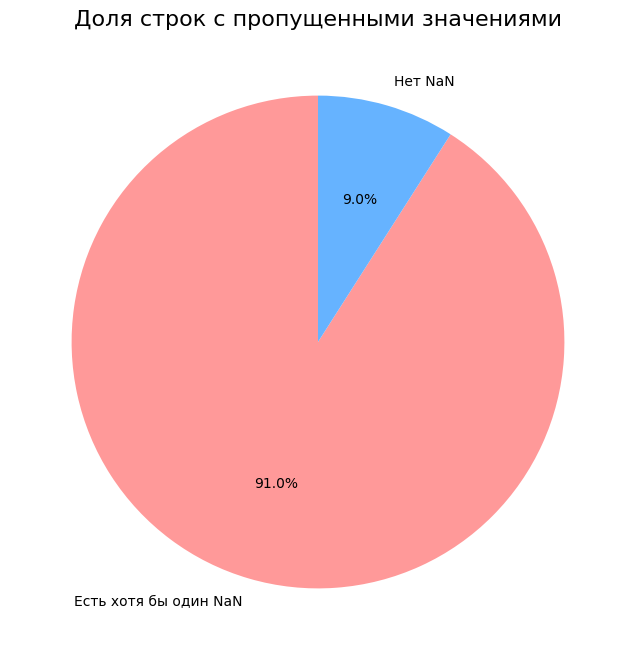

In [ ]:
# Создание нового столбца, показывающего наличие хотя бы одного NaN в строке
df_with_nan_flag = df.withColumn(
    "has_nan",
    reduce(lambda a, b: a | b, [F.col(c).isNull() | F.isnan(c) for c in df.columns])
)

# Подсчет строк с NaN и без NaN
nan_summary = df_with_nan_flag.groupBy("has_nan").count().toPandas()

# Подготовка данных для круговой диаграммы
labels = ['Есть хотя бы один NaN', 'Нет NaN']
sizes = nan_summary['count'].tolist()
if True not in nan_summary['has_nan'].tolist():
    sizes = [0, sizes[0]]  # Если нет строк с NaN
elif False not in nan_summary['has_nan'].tolist():
    sizes = [sizes[0], 0]  # Если все строки содержат NaN

# Визуализация круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Доля строк с пропущенными значениями", fontsize=16)
plt.show()


In [ ]:
# Подсчет пропусков по столбцам
nan_counts = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns])
nan_pd = nan_counts.toPandas().T.reset_index()
nan_pd.columns = ["Столбец", "Количество Nan-значений"]

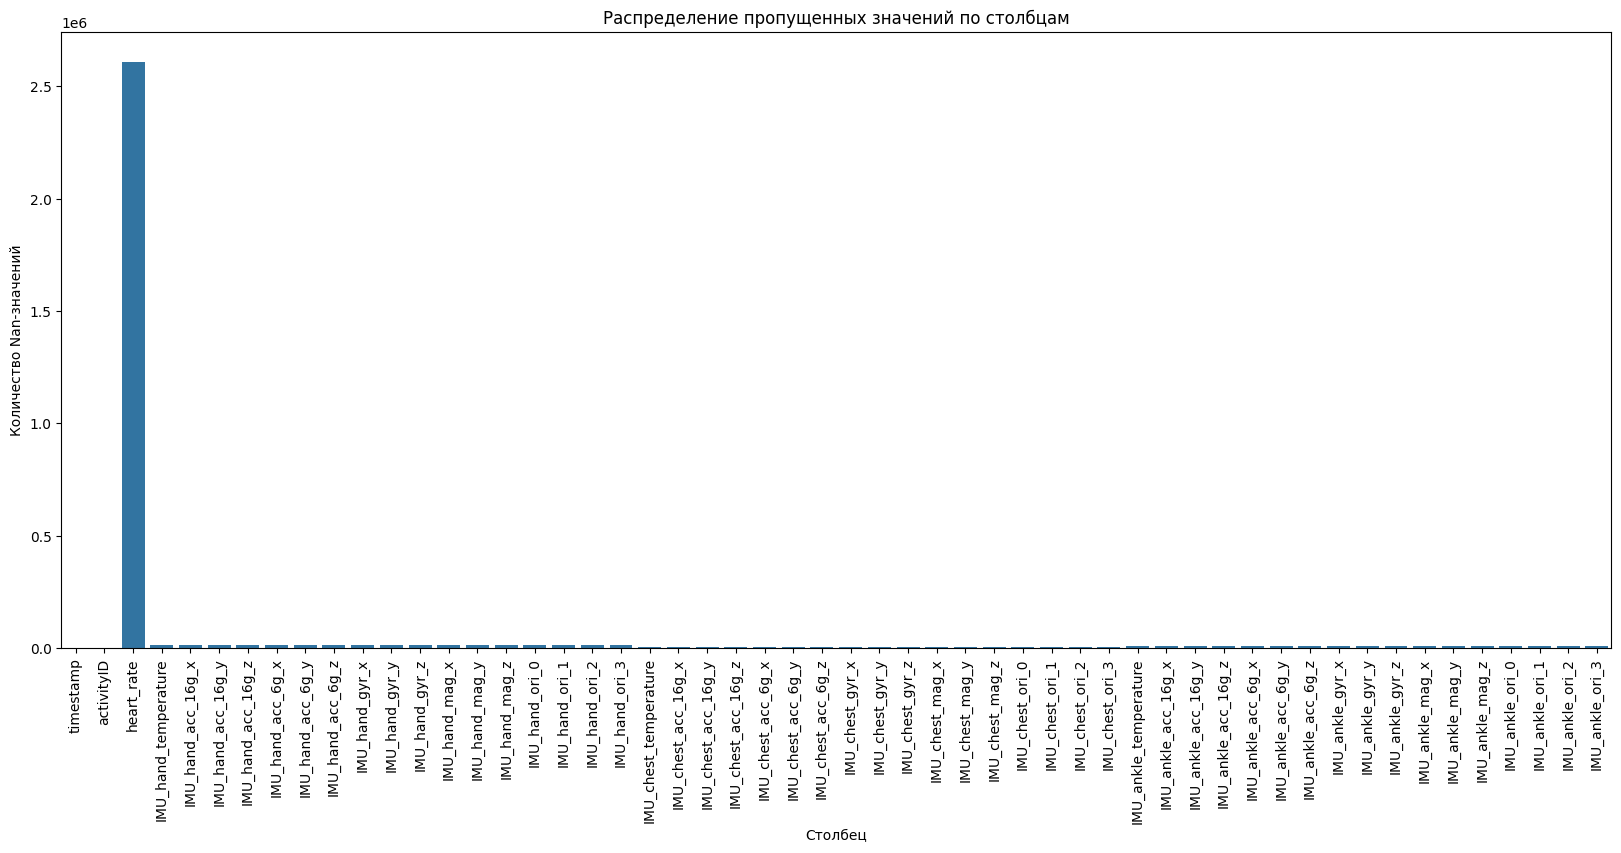

In [ ]:
# Визуализация пропусков
plt.figure(figsize=(20, 8))
sns.barplot(x="Столбец", y="Количество Nan-значений", data=nan_pd)
plt.title("Распределение пропущенных значений по столбцам")
plt.xticks(rotation=90)
plt.show()

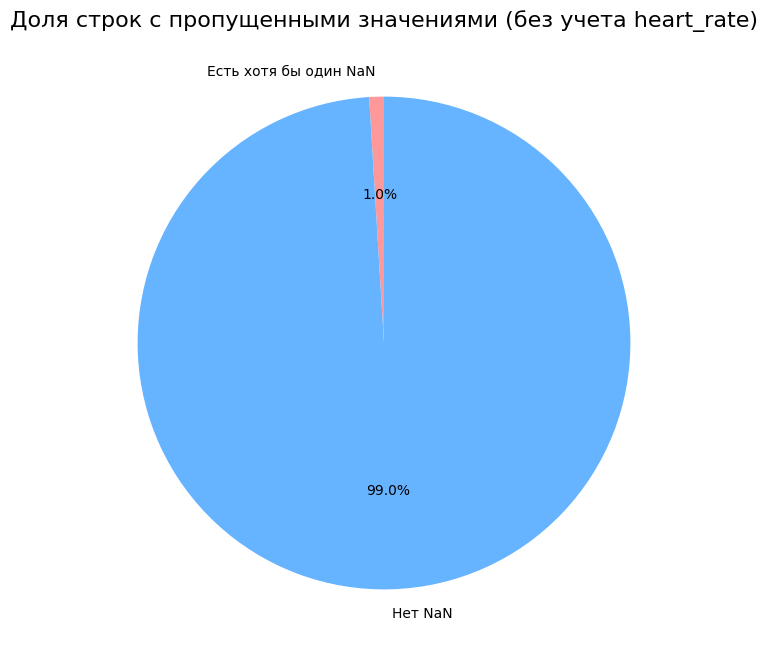

In [ ]:
# Исключаем 'heart_rate' (третий столбец) из проверки на NaN
columns_to_check = [c for i, c in enumerate(df.columns) if i != 2]

# Создание нового столбца, показывающего наличие хотя бы одного NaN (без учета 'heart_rate')
df_with_nan_excluded = df.withColumn(
    "has_nan_ex_heart_rate",
    reduce(lambda a, b: a | b, [F.col(c).isNull() | F.isnan(c) for c in columns_to_check])
)

# Подсчет строк с NaN (без учета 'heart_rate') и без NaN
nan_summary_excluded = df_with_nan_excluded.groupBy("has_nan_ex_heart_rate").count().toPandas()

# Подготовка данных для круговой диаграммы
labels_excluded = ['Есть хотя бы один NaN', 'Нет NaN']
sizes_excluded = nan_summary_excluded['count'].tolist()
if True not in nan_summary_excluded['has_nan_ex_heart_rate'].tolist():
    sizes_excluded = [0, sizes_excluded[0]]
elif False not in nan_summary_excluded['has_nan_ex_heart_rate'].tolist():
    sizes_excluded = [sizes_excluded[0], 0]

# Визуализация круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(sizes_excluded, labels=labels_excluded, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Доля строк с пропущенными значениями (без учета heart_rate)", fontsize=16)
plt.show()

In [ ]:
# Фильтруем данные, исключая activityID = 0
filtered_df = df.filter(df.activityID != 0)

# Создаем словарь для названий активностей
activity_names = {
    1: "Лежание",
    2: "Сидение",
    3: "Стояние",
    4: "Ходьба",
    5: "Бег",
    6: "Езда на велосипеде",
    7: "Скандинавская ходьба",
    12: "Подъем по лестнице",
    13: "Спуск по лестнице",
    16: "Уборка пылесосом",
    17: "Глажка",
    24: "Прыжки со скакалкой"
}


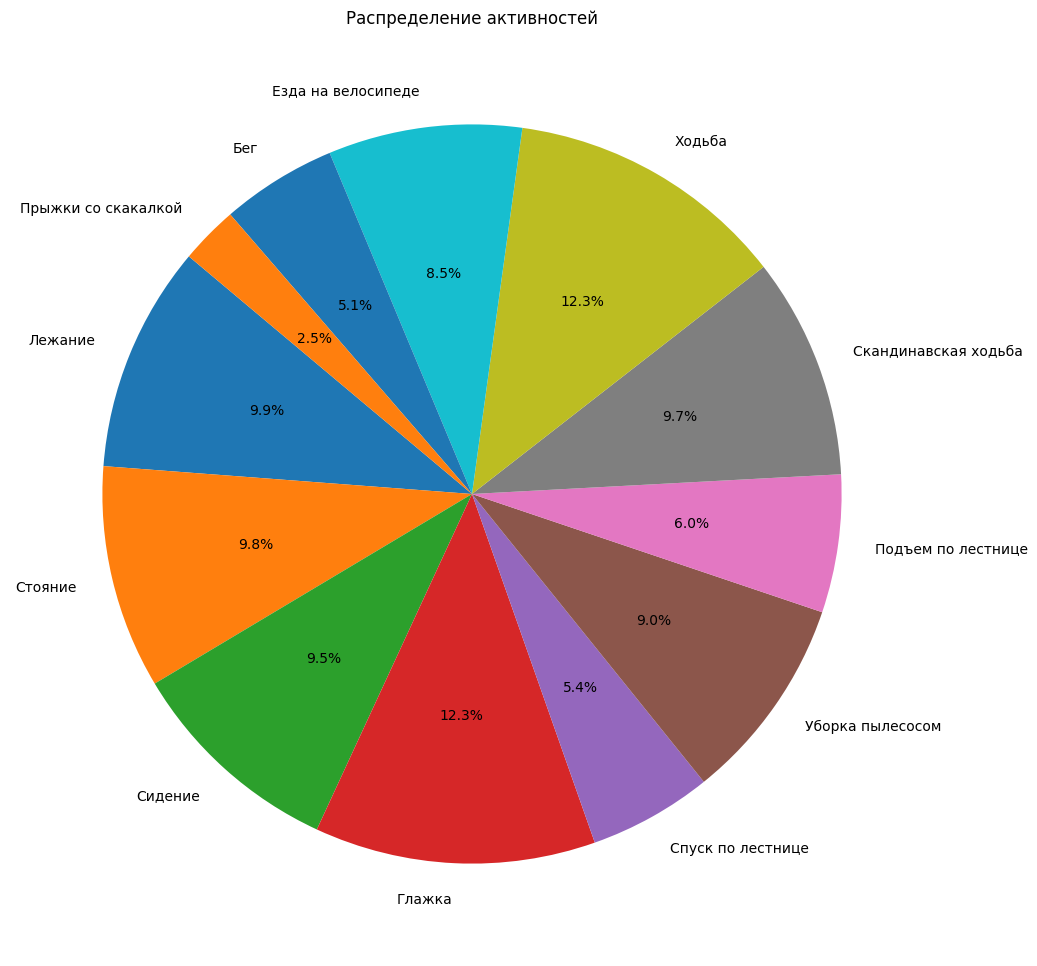

In [ ]:
# Агрегируем данные
activity_counts = filtered_df.groupBy("activityID").count().toPandas()

# Добавляем названия активностей в DataFrame
activity_counts["activity_name"] = activity_counts["activityID"].map(activity_names)

# Создаем круговую диаграмму
plt.figure(figsize=(12, 12))
plt.pie(activity_counts["count"], labels=activity_counts["activity_name"], autopct='%1.1f%%', startangle=140)
plt.title("Распределение активностей")
plt.show()

In [ ]:
# Исключаем столбец heart_rate из анализа
columns_to_check = [c for c in df.columns if c != "heart_rate" and (c == 'IMU_hand_temperature' or c == 'IMU_chest_temperature' or c == 'IMU_ankle_temperature')]

# Подсчет пропусков по столбцам
nan_counts = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in columns_to_check])
nan_pd = nan_counts.toPandas().T.reset_index()
nan_pd.columns = ["Column", "NaN Count"]

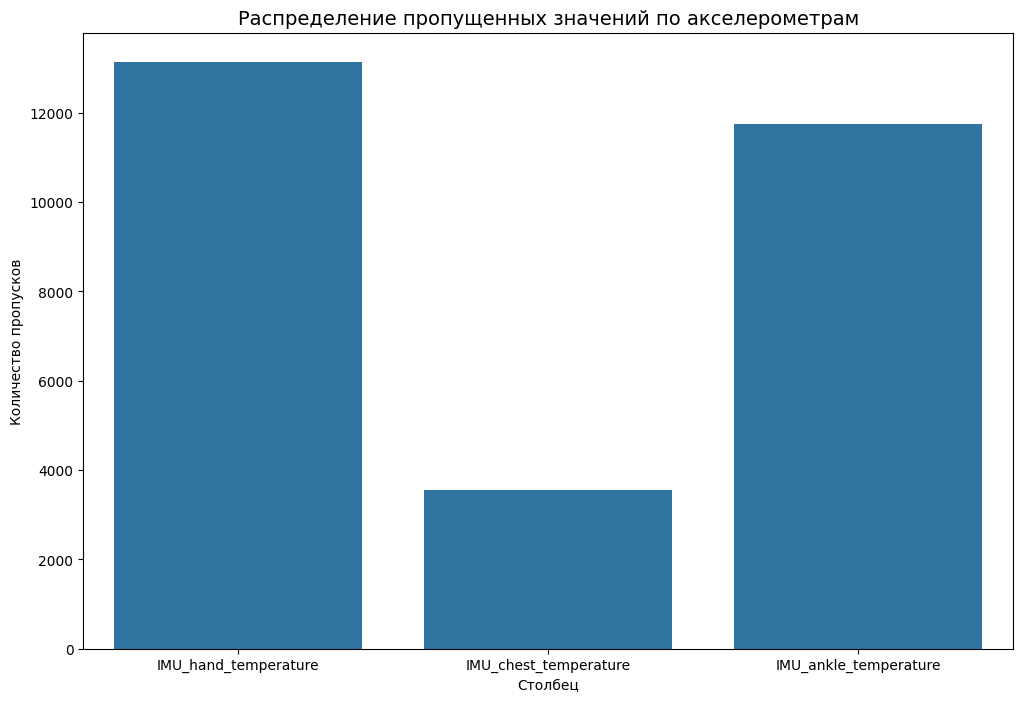

In [ ]:
# Визуализация пропусков
plt.figure(figsize=(12, 8))
sns.barplot(x="Column", y="NaN Count", data=nan_pd)
plt.title("Распределение пропущенных значений по акселерометрам", fontsize=14)
plt.xlabel("Столбец", fontsize=10)
plt.ylabel("Количество пропусков", fontsize=10)
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Получение списка файлов и обработка данных
results = {
    os.path.basename(f): sc.textFile(f)
        .map(lambda x: list(map(float, x.split(DELIMETER))))
        .toDF(ds_columns)
        .filter((F.col("activityID") != 0)
        & ~reduce(lambda a,b: a|b, [F.isnan(c)|F.col(c).isNull() for c in ds_columns]))
        .groupBy("activityID")
        .agg(F.mean("heart_rate").alias("avg_hr"))
        .toPandas()
    for f in spark.sparkContext.wholeTextFiles(DS_FILES_PATH).keys().collect()
}

# Создание итоговой таблицы
result_df = pd.DataFrame([{
    "Испытуемый": f"Испытуемый {i+1}",
    **{activity_names[row.activityID]: f"{row.avg_hr:.1f}"
       for _, row in stats.iterrows()
       if row.activityID in activity_names}
} for i, (_, stats) in enumerate(results.items())])

# Замена всех NaN и строковых вариантов
result_df = result_df.fillna('-').replace(['NaN', 'Nan', 'nan'], '-')

# Упорядочивание столбцов
result_df = result_df.reindex(columns=["Испытуемый"] + list(activity_names.values()))

print("\nТАБЛИЦА СРЕДНЕГО СЕРДЦЕБИЕНИЯ ПО АКТИВНОСТЯМ")
print(result_df.to_string(index=False, na_rep='-', max_colwidth=15, justify='center'))


ТАБЛИЦА СРЕДНЕГО СЕРДЦЕБИЕНИЯ ПО АКТИВНОСТЯМ
 Испытуемый  Лежание Сидение Стояние Ходьба  Бег  Езда на велосипеде Скандинавская ходьба Подъем по лестнице Спуск по лестнице Уборка пылесосом Глажка Прыжки со скакалкой
Испытуемый 1   87.5    91.2   103.4  120.5  161.4      127.2              139.7                144.3              138.6             130.2        99.5       165.7         
Испытуемый 2   79.6    81.0    89.5  123.0  135.9      119.6              125.8                131.0              123.4             100.5        89.2       155.9         
Испытуемый 3   74.0    76.0    84.4  118.6      -          -                  -                126.8              131.2              93.7        84.2           -         
Испытуемый 4   74.6    83.2   101.0  111.8      -      129.0              125.6                133.5              130.4             111.9       107.9           -         
Испытуемый 5   76.5    80.2    90.3  111.6  156.2      125.3              124.2                122.

In [ ]:
# Инициализация результатов
time_results = {"Начало": {}, "Середина": {}, "Конец": {}}

# Кэшируем список файлов
file_paths = spark.sparkContext.wholeTextFiles(DS_FILES_PATH).keys().collect()

for file_path in file_paths:
    file_name = os.path.basename(file_path)
    subject_id = int(file_name.replace("subject", "").replace(".dat", "")) - 100
    subject_name = f"Исп. {subject_id} ({'ж' if subject_id == 2 else 'м'})"

    df = (sc.textFile(file_path)
          .map(lambda x: list(map(float, x.split(DELIMETER))))
          .toDF(ds_columns)
          .cache()  # Кэшируем DataFrame
         )

    # Фильтрация за один проход
    df_clean = df.filter(
        (F.col("activityID") != 0) &
        ~reduce(lambda a,b: a|b, [F.isnan(c)|F.col(c).isNull() for c in ds_columns])
    )

    # Вычисляем временные границы для всего датасета
    time_stats = df_clean.agg(
        F.min("timestamp").alias("min_ts"),
        F.max("timestamp").alias("max_ts")
    ).collect()[0]

    if time_stats["min_ts"] is None:
        continue

    min_ts = time_stats["min_ts"]
    max_ts = time_stats["max_ts"]
    duration = max_ts - min_ts

    if duration == 0:
        continue

    # Векторизованное вычисление интервалов
    df_intervals = df_clean.withColumn(
        "interval",
        F.when(
            F.col("timestamp") < min_ts + duration/3, "Начало"
        ).when(
            (F.col("timestamp") >= min_ts + duration/3) &
            (F.col("timestamp") < min_ts + 2*duration/3), "Середина"
        ).otherwise("Конец")
    )

    # Агрегация за один проход
    aggregated = df_intervals.groupBy("activityID", "interval").agg(
        F.mean("heart_rate").alias("avg_hr")
    ).collect()

    # Заполнение результатов
    for row in aggregated:
        activity = activity_names.get(row["activityID"], "Unknown")
        interval = row["interval"]
        avg_hr = row["avg_hr"]

        if avg_hr is not None:
            time_results[interval].setdefault(subject_name, {})[activity] = f"{avg_hr:.1f}"
        else:
            time_results[interval].setdefault(subject_name, {})[activity] = "-"

    df.unpersist()  # Освобождаем память

# Создание таблиц
activities_order = list(activity_names.values())
for interval in ["Начало", "Середина", "Конец"]:
    df = pd.DataFrame.from_dict(time_results[interval], orient='index')
    df = df.reindex(columns=activities_order).fillna("-")

    print(f"\nТАБЛИЦА: СРЕДНЕЕ СЕРДЦЕБИЕНИЕ ({interval.upper()})")
    print(df.to_string(na_rep="-", justify='center'))
    print("\n" + "="*80)


ТАБЛИЦА: СРЕДНЕЕ СЕРДЦЕБИЕНИЕ (НАЧАЛО)
           Лежание Сидение Стояние Ходьба Бег Езда на велосипеде Скандинавская ходьба Подъем по лестнице Спуск по лестнице Уборка пылесосом Глажка Прыжки со скакалкой
Исп. 1 (м)   87.5    91.2    103.4    -     -          -                   -                   -                  -              113.5        99.5             -      
Исп. 2 (ж)   79.6    81.0     89.5    -     -          -                   -                   -                  -              101.3        89.2             -      
Исп. 4 (м)   74.6    83.2    101.0    -     -          -                   -                   -                  -                  -       107.9             -      
Исп. 5 (м)   76.5    80.2     90.3    -     -          -                   -                   -                  -               88.8        89.7             -      
Исп. 6 (м)   71.0    77.0     84.8    -     -          -                   -                   -                  -          

In [ ]:
# Получаем список всех файлов .dat
file_list = [os.path.basename(f) for f in spark.sparkContext.wholeTextFiles(DS_FILES_PATH).keys().collect()]

# Обработка файлов и вычисление температур
temperature_results = {
    file_path: sc.textFile(f"/content/drive/MyDrive/PAMAP2_Dataset/Protocol/{file_path}")
        .map(lambda x: list(map(float, x.split(DELIMETER))))
        .toDF(ds_columns)
        .filter((F.col("activityID") != 0)
        & ~(F.isnan("IMU_hand_temperature")
        | F.isnan("IMU_chest_temperature")
        | F.isnan("IMU_ankle_temperature")))
        .groupBy("activityID")
        .agg(*(F.mean(c).alias(c) for c in [
            "IMU_hand_temperature",
            "IMU_chest_temperature",
            "IMU_ankle_temperature"
        ])).toPandas()
    for file_path in file_list
}

# Генерация структуры таблицы
sensors = {"Рука": "hand", "Грудь": "chest", "Лодыжка": "ankle"}
columns = [f"{activity} ({sensor})"
          for activity, sensor in product(activity_names.values(), sensors)]

result_df = pd.DataFrame([{
    "Испытуемый": f"Испытуемый {i+1}",
    **{f"{activity_names[row.activityID]} ({sensor})":
        f"{getattr(row, f'IMU_{sens_part}_temperature'):.1f}°C"
        for sensor, sens_part in sensors.items()
        for _, row in stats.iterrows()
        if row.activityID in activity_names}
} for i, (_, stats) in enumerate(temperature_results.items())])

# Заполнение отсутствующих значений и вывод
result_df = result_df.reindex(columns=["Испытуемый"] + columns).fillna("-")
print("\nТАБЛИЦА СРЕДНИХ ТЕМПЕРАТУР ПО АКТИВНОСТЯМ")
print(result_df.to_string(index=False, max_colwidth=20, justify='center'))


ТАБЛИЦА СРЕДНИХ ТЕМПЕРАТУР ПО АКТИВНОСТЯМ
 Испытуемый  Лежание (Рука) Лежание (Грудь) Лежание (Лодыжка) Сидение (Рука) Сидение (Грудь) Сидение (Лодыжка) Стояние (Рука) Стояние (Грудь) Стояние (Лодыжка) Ходьба (Рука) Ходьба (Грудь) Ходьба (Лодыжка) Бег (Рука) Бег (Грудь) Бег (Лодыжка) Езда на велосипеде (Рука) Езда на велосипеде (Грудь) Езда на велосипеде (Лодыжка) Скандинавская ходьба (Рука) Скандинавская ходьба (Грудь) Скандинавская ходьба (Лодыжка) Подъем по лестнице (Рука) Подъем по лестнице (Грудь) Подъем по лестнице (Лодыжка) Спуск по лестнице (Рука) Спуск по лестнице (Грудь) Спуск по лестнице (Лодыжка) Уборка пылесосом (Рука) Уборка пылесосом (Грудь) Уборка пылесосом (Лодыжка) Глажка (Рука) Глажка (Грудь) Глажка (Лодыжка) Прыжки со скакалкой (Рука) Прыжки со скакалкой (Грудь) Прыжки со скакалкой (Лодыжка)
Испытуемый 1     31.3°C          33.1°C           31.7°C          32.3°C          34.0°C           32.7°C          32.9°C          34.5°C           33.3°C          33.2°C      

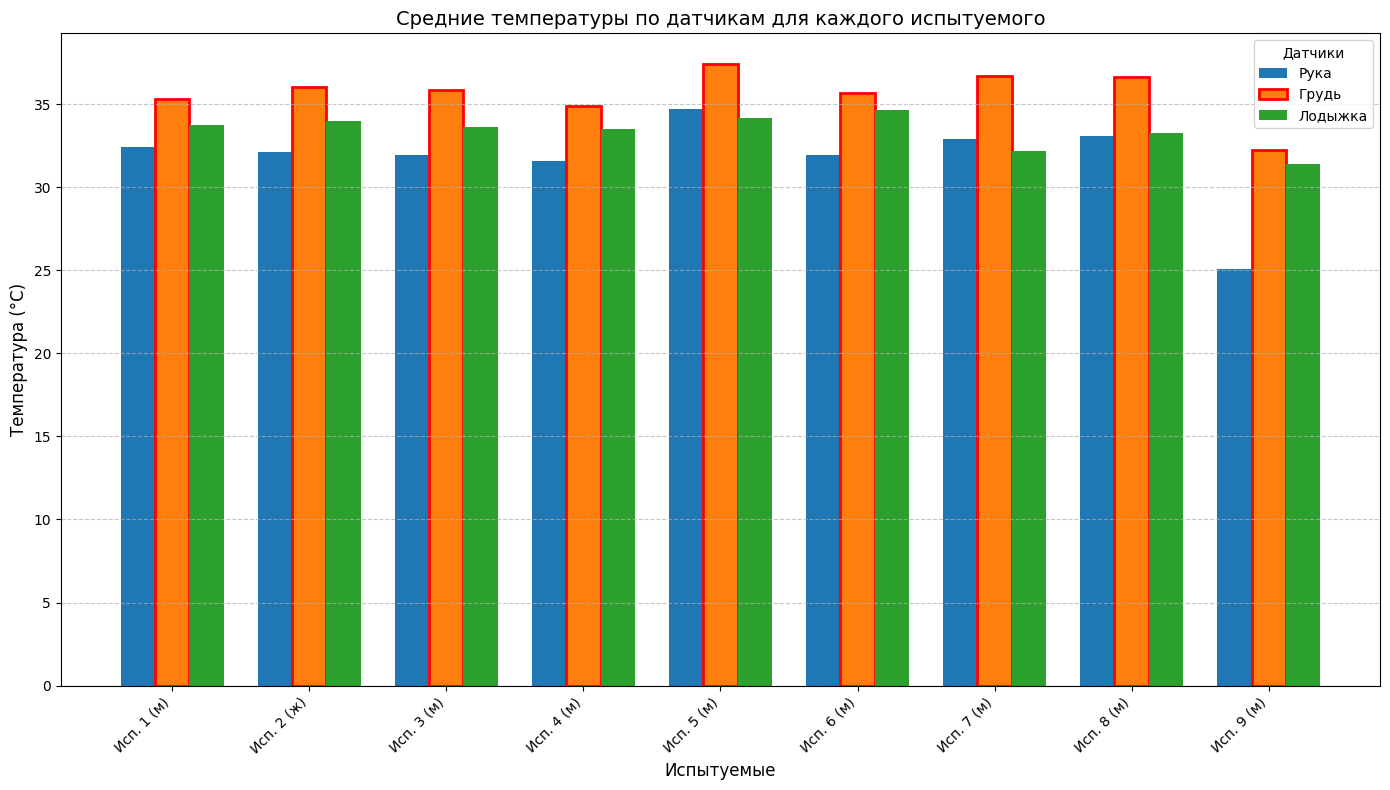

In [ ]:
# Собираем средние температуры по всем активностям для каждого субъекта
subject_data = []
for subj_id, (file_path, stats) in enumerate(temperature_results.items()):
    # Фильтруем валидные активности
    valid_stats = stats[stats.activityID.isin(activity_names.keys())]

    # Собираем средние значения по всем активностям для каждого датчика
    sensor_means = {
        'Рука': valid_stats['IMU_hand_temperature'].mean(),
        'Грудь': valid_stats['IMU_chest_temperature'].mean(),
        'Лодыжка': valid_stats['IMU_ankle_temperature'].mean()
    }

    subject_data.append({
        'subject': f"Исп. {subj_id+1} ({'ж' if subj_id == 1 else 'м'})",
        **sensor_means
    })

df = pd.DataFrame(subject_data).set_index('subject')

fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 0.25
x = np.arange(len(df))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, sensor in enumerate(['Рука', 'Грудь', 'Лодыжка']):
    ax.bar(x + i*bar_width,
           df[sensor],
           width=bar_width,
           label=sensor,
           color=colors[i])

for bar in ax.patches[len(df)*1:len(df)*2]:
    bar.set_edgecolor('red')
    bar.set_linewidth(2)

ax.set_title('Средние температуры по датчикам для каждого испытуемого', fontsize=14)
ax.set_xlabel('Испытуемые', fontsize=12)
ax.set_ylabel('Температура (°C)', fontsize=12)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(df.index, rotation=45, ha='right')
ax.legend(title='Датчики')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()